In [2]:
import sys
import numpy as np
from tqdm import tqdm_notebook
import pickle
import json as js
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init_common as x
import simulate_corona_inout as sc
import multiprocessing as mp
from functools import partial
import helpers as hp

## setting
alpha_const = True
alpha_val0 = 0.5
alpha_val1 = 1
R0 = x.R0_default

Trec_const = False
beta_mixed = True

## setup
out_filename_dir,out_fig_dir,out_stat_dir=hp.setup_paths(R0,alpha_val0,"inout")
out_filename = out_filename_dir+"/"+x.out_filename
out_filename_info = out_filename_dir+"/info.json"
# choose distribution for beta and gammma
if beta_mixed:
    if Trec_const:
        import init_spec_beta as xx
    else:
        import init_spec_beta_gamma as xx
else:
    import init_spec_gamma as xx

# alpha-strategy
if alpha_const:
    alpha_mat0 = np.full([x.N_locs,x.N_per],alpha_val0)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)
else:
    idx_sel = np.arange(0,x.N_locs)
    tar_sel = 1
    per = 50
    init_rem = 1
    tar_rem = 1
    alpha_mat0 = hp.create_alpha_matrix(idx_sel,alpha_val0,tar_sel,per,init_rem,tar_rem)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)

# get random vectors and rescale R0 if needed
R0_scale = R0/x.R0_default
beta_list,Trec_list = xx.get_vectors(R0_scale)

## initialize
rep_vec = np.arange(0,x.N_simul)

def run_simulation(beta_list,Trec_list,alpha_mat0,alpha_mat1):
    fun = partial(sc.simul,beta_list,Trec_list,alpha_mat0,alpha_mat1)
    cores_cnt = mp.cpu_count()
    run_cnt = int(np.ceil(x.N_simul/cores_cnt))
    res = []
    dt_avg = 0
    for run_idx in np.arange(run_cnt):
        pool = mp.Pool(cores_cnt)
        tic = time.perf_counter()
        res0 = pool.map(fun,np.arange(0,cores_cnt))
        toc = time.perf_counter()
        pool.close()
        dt_avg += (toc-tic)
        res = res+res0
    dt_avg /= x.N_simul
    return res,dt_avg 

def save_results(filename,data,stat=False):
    if stat:       
        pct_S_mean = hp.mean_list(data,'sus')
        pct_I_mean = hp.mean_list(data,'inf')
        pct_R_mean = hp.mean_list(data,'rec')
        pct_S_q95 = hp.quant_list(data,'sus',.95)
        pct_I_q95 = hp.quant_list(data,'inf',.95)
        pct_R_q95 = hp.quant_list(data,'rec',.95)        
        pct_S_q05 = hp.quant_list(data,'sus',.05)
        pct_I_q05 = hp.quant_list(data,'inf',.05)
        pct_R_q05 = hp.quant_list(data,'rec',.05)
        data_stat = pd.DataFrame(list(zip(pct_S_mean, pct_I_mean, pct_R_mean, pct_S_q95,pct_I_q95,pct_R_q95,pct_S_q05,pct_I_q05,pct_R_q05)), 
                         columns = ['sus_mean','inf_mean','rec_mean','sus_q95','inf_q95','rec_q95','sus_q05','inf_q05','rec_05'])
        with open(filename+"_stat.pickle","wb") as fid_stat:
            pickle.dump(data_stat,fid_stat)
        fid_stat.close()
    with open(filename+".pickle",'wb') as fid:
        pickle.dump(data,fid)
    fid.close()
    dic = {"R0":R0,"alpha0":alpha_val0,"alpha1":alpha_val1,"Trec_const":Trec_const,"inout":True,"beta":beta_mixed}
    with open(out_filename_info,"w") as fid:
        js.dump(dic,fid)
    fid.close()

if alpha_const:
    print("Alpha0: "+str(np.round(alpha_val0,3)))
    print("Alpha1: "+str(np.round(alpha_val1,3)))
else:
    print("Alpha: plan")
print("R0:"+str(np.round(R0,3))+"\t (default value = "+str(np.round(x.R0_default,3))+")")
print("Recovery Time constant: "+str(Trec_const))
print("Beta tail follows Power distribution: "+str(beta_mixed))

print("Running simulation ... ",end="",flush=True)
data,tpi=run_simulation(beta_list,Trec_list,alpha_mat0,alpha_mat1)
print("Finished")
print("Time per iteration (sec.): "+str(tpi))

## save results
print("Saving results ...",end="",flush=True)
save_results(out_filename,data,stat=False)
print("Finished")    
    

Alpha0: 0.5
Alpha1: 1
R0:1.48	 (default value = 1.48)
Recovery Time constant: False
Beta tail follows Power distribution: True
Running simulation ... Finished
Time per iteration (sec.): 4.796764817156252
Saving results ...Finished


Basic Statistics: number of infected people
Peak, mean value:  169.0  day:  0
Peak, mean+2*std value :  410.0  day:  69
Peak, mean-2*std value :  131.0  day:  69


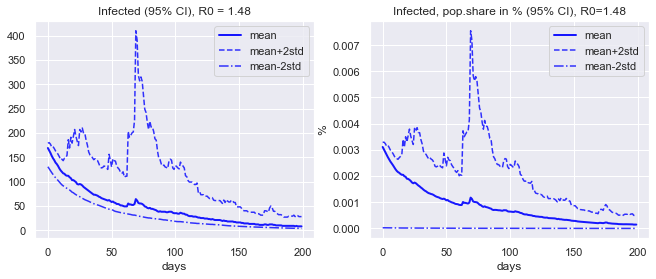

In [3]:
# Basic statistics
# 1. Peak of infected, 95% CI
I_mean = hp.mean_list(data,'inf')
I_std = hp.std_list(data,'inf')
print("Basic Statistics: number of infected people")
m = np.round(x.N_popul_size*np.array(I_mean)/x.first_infections_correction_multiplier)
s = np.round(x.N_popul_size*np.array(I_std)/x.first_infections_correction_multiplier)
m1=m+2*s
xval=np.arange(0,x.N_per)
m0 = hp.fun_log_list(data,'inf',fun=np.mean,ma=False,w=6,s=x.N_popul_size/x.first_infections_correction_multiplier)
tstat_95 = 2.262
s0 = hp.fun_log_list(data,'inf',fun=np.std,ma=False,w=6,s=x.N_popul_size/x.first_infections_correction_multiplier)
ds0 = tstat_95*s0/x.N_simul**.5
m2 = np.exp(m0-ds0)
print('Peak, mean value: ',np.round(m.max()),' day: ',m.argmax())
print('Peak, mean+2*std value : ',np.round(m1.max()),' day: ',m1.argmax())
print('Peak, mean-2*std value : ',np.round(m2.max()),' day: ',m1.argmax())    
plt.subplot(121)
plt.plot(xval,m,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,m1,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,m2,color='blue',linestyle='-.',alpha=.8)
plt.legend(['mean', 'mean+2std', 'mean-2std'])
plt.xlabel("days")
plt.title("Infected (95% CI), R0 = "+ str(np.round(R0,2)))

m = 100*np.array(I_mean)/x.first_infections_correction_multiplier
s = 100*np.array(I_std)/x.first_infections_correction_multiplier
m1=m+2*s
xval=np.arange(0,x.N_per)
m0 = hp.fun_log_list(data,'inf',fun=np.mean,ma=False,w=6,s=1/x.first_infections_correction_multiplier)
tstat_95 = 2.262
s0 = hp.fun_log_list(data,'inf',fun=np.std,ma=False,w=6,s=1/x.first_infections_correction_multiplier)
ds0 = tstat_95*s0/x.N_simul**.5
m2 = np.exp(m0-ds0)   
plt.subplot(122)
plt.plot(xval,m,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,m1,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,m2,color='blue',linestyle='-.',alpha=.8)
plt.legend(['mean', 'mean+2std', 'mean-2std'])
plt.ylabel("%")
plt.xlabel("days")
plt.title("Infected, pop.share in % (95% CI), R0="+ str(np.round(R0,2)))

plt.savefig("peaks.png",dpi=300)

In [ ]:
I_in = np.round(-x.N_popul_size*np.array(hp.mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier)
I_out = np.round(x.N_popul_size*np.array(hp.mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier)
dI = np.round(x.N_popul_size*np.array(hp.mean_diff_list(data,'inf'))/x.first_infections_correction_multiplier)
xval = np.arange(1,x.N_per)

plt.subplot(121)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_out,color='green',linewidth=2,alpha=.9)
plt.plot(xval,dI,color='red',linewidth=2,alpha=.9)
plt.legend(['Newly Infected','Newly Recovered','Total Change'])
plt.title('Evolution of changes in infected')

plt.savefig("change.png",dpi=300)

I_in = -100*np.array(hp.mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier
I_out = 100*np.array(hp.mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier
dI = 100*np.array(hp.mean_diff_list(data,'inf'))/x.first_infections_correction_multiplier
xval = np.arange(1,x.N_per)
plt.subplot(122)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_out,color='green',linewidth=2,alpha=.9)
plt.plot(xval,dI,color='red',linewidth=2,alpha=.9)
plt.legend(['Newly Infected','Newly Recovered','Total Change'])
plt.xlabel("days")
plt.ylabel("%")
plt.title('Evolution of changes in infected (%)')
